In [1]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [2]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


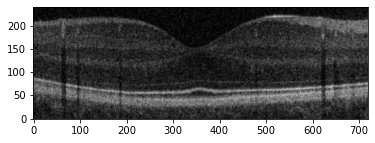

In [3]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [4]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta + self.dgamma), self.y + self.dr * np.sin(self.theta + self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1, p2]))
    def control_points(self):
        return self.bezier.control_points

    def path(self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch(self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points(self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r / 8)))
        return self.bezier.point_at_t(np.linspace(0, 1, intervals))

    def approx_length(self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates, intermediates)
        return np.sum(np.diag(eds, 1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1, 2)))
        colours = [image[point[0], point[1]] for point in intermediates]
        return np.array(colours) / 255

    # Added size and distance_to methods to the camo worm class to return worm size and distance between worms
    def size(self):
        return self.r
    
    def width(self):
        return width.r

    # Distance function calculated using Euclidean distance
    def distance_to(self, other_worm):
        distance = ((self.x - other_worm.x) ** 2 + (self.y - other_worm.y) ** 2) ** 0.5
        return distance

    # testing colour cost function
    def color_similarity(self, background_color):
        similarity = np.linalg.norm(self.colour - background_color)
        return similarity



    def average_background_color(self, image, radius):
        # Convert the coordinates to integers
        min_y = int(max(0, self.y - radius))
        max_y = int(min(image.shape[0], self.y + radius))
        min_x = int(max(0, self.x - radius))
        max_x = int(min(image.shape[1], self.x + radius))

        # Slice the image using integer indices
        background_pixels = image[min_y:max_y, min_x:max_x]

        # Calculate the average color
        avg_color = np.mean(background_pixels, axis=(0, 1))
        return avg_color


In [5]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [6]:
def random_worm(imshape, init_params):
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = init_params[0] * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = init_params[1] * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = init_params[2] * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

In [7]:
#Cost Functions separated

def distance_constraint(new_worm, existing_worms):
    for worm in existing_worms:
        if new_worm.distance_to(worm) < 10:
            return False
    return True

def size_constraint(new_worm):
    return new_worm.size() > 50 and new_worm.width <1

def color_constraint(new_worm, image, background_radius=0.5, color_threshold=50):
    #background_color = new_worm.average_background_color(image, background_radius)
    background_color = new_worm.average_background_color(image, background_radius)
    similarity = new_worm.color_similarity(background_color)
    return similarity < color_threshold

In [8]:
def combined_constraint(new_worm, existing_worms, image, background_radius=0.5, color_threshold=50):
    # Distance constraint
    for worm in existing_worms:
        if new_worm.distance_to(worm) < 10:
            return False
    
    # Size constraint
    if new_worm.size() <= 50 or new_worm.width >= 1:
        return False
    
    # Color constraint
    background_color = new_worm.average_background_color(image, background_radius)
    similarity = new_worm.color_similarity(background_color)
    if similarity >= color_threshold:
        return False
    
    return True


In [9]:
def initialise_clew(size, imshape, init_params):
    clew = []
    while True:
        new_worm = random_worm(imshape, init_params)
        #if distance_constraint(new_worm, clew) and size_constraint(new_worm) and color_constraint(new_worm, image):
        if combined_constraint(new_worm, clew, image):
            clew.append(new_worm)
            if len(clew) == size:
                return clew
            


Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


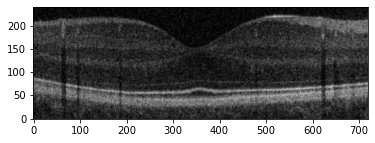

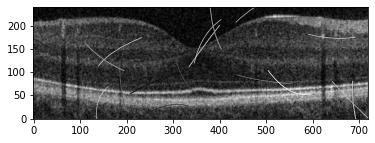

In [11]:
# Initialise clew and draw
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Can change the number of worms, if functions keeps on running, try to modify this or the threshold as we might be trying to generate more worms than possible 
clew = initialise_clew(20, image.shape, (20, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

In [13]:
import random

def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        # Generate random individual (worm parameters)
        individual = generate_random_individual()
        population.append(individual)
    return population

def generate_random_individual():
    position = random.randint(1, 10)
    size = random.randint(10, 50)
    width = random.randint(1, 10)
    background_radius = random.uniform(0.5, 3)
    background_color = random.randint(0, 100)
    
    return [position, size, width, background_radius, background_color]

# Tournament function
def select_parents(population, fitness_scores, tournament_size=3):
    selected_parents = []
    for _ in range(len(population)):
        tournament = random.sample(fitness_scores, tournament_size)
        winner = max(tournament, key=lambda x: x[1])  # Select individual with highest fitness
        selected_parents.append(winner[0])
    return selected_parents

# Crossover Function
def crossover(parents, crossover_rate=0.8):
    offspring = []
    for i in range(0, len(parents), 2):
        parent1 = parents[i]
        parent2 = parents[i+1]
        if random.random() < crossover_rate:
            crossover_point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            offspring.append(child1)
            offspring.append(child2)
        else:
            offspring.append(parent1)
            offspring.append(parent2)
    return offspring

# Mutation Function
def mutate(offspring, mutation_rate=0.1):
    mutated_offspring = []
    for individual in offspring:
        if random.random() < mutation_rate:
            # Randomly select a parameter to mutate (e.g., position, size, width)
            mutation_point = random.randint(0, len(individual) - 1)
            # Mutate the selected parameter
            individual[mutation_point] = mutate_parameter(individual[mutation_point])
        mutated_offspring.append(individual)
    return mutated_offspring

def mutate_parameter(parameter):
    # mutate the parameter by a fixed amount
    mutation_amount = 1
    mutated_parameter = parameter + mutation_amount
    return mutated_parameter
    return mutated_parameter

def select_new_population(population, offspring):
    # Combine parents and offspring
    combined_population = population + offspring
    # Sort combined population by fitness (optional)
    combined_population.sort(key=lambda x: combined_constraint(x))
    # Select top individuals to form the new population
    new_population = combined_population[:len(population)]
    return new_population



# Main genetic algorithm function
def genetic_algorithm(population_size, generations):
    population = initialize_population(population_size)
    for gen in range(generations):
        # Evaluate population
        fitness_scores = []
        for individual in population:
            fitness = combined_constraint(individual)
            fitness_scores.append((individual, fitness))
        
        # Selection
        selected_parents = select_parents(population, fitness_scores)
        
        # Crossover
        offspring = crossover(selected_parents)
        
        # Mutation
        mutated_offspring = mutate(offspring)
        
        # Replacement
        population = select_new_population(population, mutated_offspring)
        
        # Check for termination condition (optional)
        if termination_condition_met():
            break
    
    # Return best individual found
    best_individual = select_best_individual(population)
    return best_individual




In [14]:
# Define parameters
population_size = 100
generations = 50

# Run the genetic algorithm
best_individual = genetic_algorithm(population_size, generations)

# Output the best individual found
print("Best individual:", best_individual)


TypeError: combined_constraint() missing 2 required positional arguments: 'existing_worms' and 'image'

&copy; Cara MacNish, UWA, 2024